In [15]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn
import os
import json

print(f"numpy=={numpy.__version__}")
print(f"pandas=={pandas.__version__}")
print(f"scipy=={scipy.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"seaborn=={seaborn.__version__}")



# FOLDER_PATH = "server_logs_multinum"
# OUTPUT_FILE = "pooled_data.csv"

# # Collect JSON files
# files = [
#     os.path.join(FOLDER_PATH, f)
#     for f in os.listdir(FOLDER_PATH)
#     if f.endswith(".json")
# ]

# # Sort by modification time (latest first)
# files.sort(key=os.path.getmtime, reverse=True)

# events_list = []
# user_details_list = []

# for file_path in files:
#     try:
#         with open(file_path, "r") as f:
#             data = json.load(f)

#         # Handle double-encoded JSON
#         if isinstance(data, str):
#             data = json.loads(data)

#         if not isinstance(data, dict):
#             print(f"Unexpected format: {file_path}")
#             continue

#     except (json.JSONDecodeError, OSError):
#         print(f"Error reading file: {file_path}")
#         continue

#     # ----------------------
#     # User details
#     # ----------------------
#     user_details = data.get("userDetails", {})

#     # Create anonymised userId
#     contact = str(user_details.get("contactNumber", ""))
#     if len(contact) >= 4:
#         user_id = contact[-4:]
#     else:
#         name = str(user_details.get("participantName", "anon"))
#         user_id = name[-4:]

#     # Time variables (seconds)
#     start_time = pd.to_numeric(user_details.get("participantSeed"), errors="coerce") / 1000
#     end_time = pd.to_numeric(user_details.get("endTime"), errors="coerce") / 1000
#     total_dur = (end_time - start_time) / 60

#     # ----------------------
#     # Events
#     # ----------------------
#     events = data.get("events", [])
#     if not events:
#         continue

#     events_df = pd.json_normalize(events)

#     # Add anonymised + demographic + timing info
#     events_df["userId"] = user_id
#     events_df["age"] = user_details.get("age", np.nan)
#     events_df["gender"] = user_details.get("gender", np.nan)
#     events_df["start_time"] = start_time
#     events_df["end_time"] = end_time
#     events_df["total_dur"] = total_dur

#     events_list.append(events_df)
# # ----------------------
# # Combine all data
# # ----------------------
# all_data = pd.concat(events_list, ignore_index=True)

# # Clean demographics
# all_data["age"] = pd.to_numeric(all_data["age"], errors="coerce")
# all_data["gender"] = all_data["gender"].astype("category")

# # ----------------------
# # Save anonymised pooled file
# # ----------------------
# all_data.to_csv(OUTPUT_FILE, index=False)

# print(f"Saved anonymised data to {OUTPUT_FILE}")

numpy==1.26.4
pandas==2.2.3
scipy==1.15.2
matplotlib==3.10.1
seaborn==0.13.2


In [16]:
all_data = pd.read_csv('data/pooled_data.csv')

In [17]:
def preprocess_behavioral_data(
    df,
    participant_col="userId",
    trial_type_col="trial_type",
    response_col="response",
    target_col="target",
    rt_col="duration",
    min_rt=100,
    catch_accuracy_threshold=0.80,
    validity_threshold=0.80,
    total_expected_trials_per_participant=None,
):
    """
    Preprocess behavioral RT data with accuracy- and RT-based exclusions.

    Steps (in order):
    1. Exclude participants failing catch trials.
    2. Remove trials with missing data or RT < min_rt.
    3. Identify participants with severe missingness (optional).
    4. Remove RT outliers using participant-specific thresholds.
    5. Exclude participants with insufficient valid trials.
    
    Returns:
        df_clean: Trial-level cleaned DataFrame
        removed_users: Participant-level exclusion summary
        summary_text: Methods-style summary paragraph
    """

    df = df.copy()

    # -------------------------
    # Initial participant count
    # -------------------------
    n_initial_participants = df[participant_col].nunique()

    # -------------------------
    # 1. Catch trial accuracy
    # -------------------------
    catch_df = df[df[trial_type_col] != "main"].copy()
    catch_df["correct"] = catch_df[response_col] == catch_df[target_col]

    catch_acc = (
        catch_df.groupby(participant_col)["correct"]
        .mean()
        .fillna(0)
    )

    catch_excluded = set(
        catch_acc[catch_acc < catch_accuracy_threshold].index
    )

    # -------------------------
    # 2. Basic trial cleaning
    # -------------------------
    df = df.dropna(subset=[participant_col, rt_col, response_col])
    df = df[df[rt_col] >= min_rt]

    # -------------------------
    # 3. Severe missingness
    # -------------------------
    if total_expected_trials_per_participant:
        trial_counts = df.groupby(participant_col).size()
        missing_excluded = set(
            trial_counts[
                trial_counts < 0.2 * total_expected_trials_per_participant
            ].index
        )
    else:
        missing_excluded = set()

    # -------------------------
    # 4. RT outliers (within participant)
    # -------------------------
    q75 = df.groupby(participant_col)[rt_col].transform(lambda x: x.quantile(0.75))
    q25 = df.groupby(participant_col)[rt_col].transform(lambda x: x.quantile(0.25))
    iqr = q75 - q25

    df["valid_rt"] = df[rt_col] <= (q75 + 1.75 * iqr)

    # -------------------------
    # 5. Valid-trial proportion
    # -------------------------
    total_trials = df.groupby(participant_col).size()
    valid_trials = df[df["valid_rt"]].groupby(participant_col).size()
    valid_ratio = (valid_trials / total_trials).fillna(0)

    validity_excluded = set(
        valid_ratio[valid_ratio < validity_threshold].index
    )

    # -------------------------
    # Retained participants
    # -------------------------
    retained_users = (
        set(valid_ratio.index)
        - catch_excluded
        - missing_excluded
        - validity_excluded
    )

    # -------------------------
    # Participant exclusion table
    # -------------------------
    removed_users = pd.DataFrame({
        participant_col: valid_ratio.index,
        "total_trials": total_trials,
        "valid_trials": valid_trials.reindex(total_trials.index, fill_value=0),
        "valid_pct": (valid_ratio * 100).round(2),
        "failed_catch": [u in catch_excluded for u in valid_ratio.index],
        "severe_missingness": [u in missing_excluded for u in valid_ratio.index],
        "low_validity": [u in validity_excluded for u in valid_ratio.index],
    })

    removed_users = removed_users[
        removed_users["failed_catch"]
        | removed_users["severe_missingness"]
        | removed_users["low_validity"]
    ]

    # -------------------------
    # Final cleaned data
    # -------------------------
    df_clean = df[
        df[participant_col].isin(retained_users) & df["valid_rt"]
    ].drop(columns="valid_rt")

    # -------------------------
    # Summary (Methods-ready)
    # -------------------------
    n_retained = df_clean[participant_col].nunique()
    trials_before = df.shape[0]
    trials_after = df_clean.shape[0]
    trials_removed = trials_before - trials_after
    pct_removed = 100 * trials_removed / trials_before

    summary_text = (
        f"Data were collected from {n_initial_participants} participants. "
        f"{len(catch_excluded)} participant(s) were excluded for failing to meet "
        f"the predefined accuracy criterion on catch trials "
        f"(accuracy < {int(catch_accuracy_threshold * 100)}%). "
        f"{len(missing_excluded)} participant(s) were excluded due to extensive "
        f"missing response-time data. "
        f"{len(validity_excluded)} participant(s) were excluded for having fewer "
        f"than {int(validity_threshold * 100)}% valid trials. "
        f"This left {n_retained} participants for subsequent analyses. "
        f"At the trial level, responses with RTs shorter than {min_rt} ms or "
        f"exceeding a participant-specific upper threshold "
        f"(defined as the 75th percentile plus 1.75 × the interquartile range) "
        f"were excluded. In total, {trials_removed} trials ({pct_removed:.1f}%) "
        f"were removed, leaving {trials_after} trials for analysis."
    )

    print("\n" + summary_text)

    return df_clean, removed_users, summary_text

In [18]:
clean_df, excluded_participants, methods_text = preprocess_behavioral_data(
    all_data,
    participant_col="userId",
    trial_type_col="trial_type",
    response_col="response",
    target_col="target",
    rt_col="duration",
    min_rt=100,
    catch_accuracy_threshold=0.80,
    validity_threshold=0.80,
    total_expected_trials_per_participant=180,
)


Data were collected from 18 participants. 1 participant(s) were excluded for failing to meet the predefined accuracy criterion on catch trials (accuracy < 80%). 0 participant(s) were excluded due to extensive missing response-time data. 0 participant(s) were excluded for having fewer than 80% valid trials. This left 17 participants for subsequent analyses. At the trial level, responses with RTs shorter than 100 ms or exceeding a participant-specific upper threshold (defined as the 75th percentile plus 1.75 × the interquartile range) were excluded. In total, 221 trials (12.8%) were removed, leaving 1506 trials for analysis.


In [19]:
clean_df.to_csv('clean_data.csv', index=False) 

In [20]:
def calculate_rst_ew(df):
    """
    Computes the Relative Selection of the Target (RST) using equal weighting
    across target conditions (A and C).

    RST is defined as the mean of:
        P(select Target | Target = A)
        P(select Target | Target = C)

    Catch trials are excluded.
    """

    df = df[df["trial_type"] != "catch"].copy()

    # Count responses conditional on target
    counts = (
        df.groupby(["target", "response"])
        .size()
        .unstack(fill_value=0)
    )

    # Extract counts (safe even if columns are missing)
    n_T1 = counts.at["A", "A"] if "A" in counts.index else 0
    n_C1 = counts.at["A", "C"] if "A" in counts.index else 0
    n_D1 = counts.at["A", "B"] if "A" in counts.index else 0

    n_T2 = counts.at["C", "C"] if "C" in counts.index else 0
    n_C2 = counts.at["C", "A"] if "C" in counts.index else 0
    n_D2 = counts.at["C", "B"] if "C" in counts.index else 0

    # Compute condition-specific RST
    rst_c1 = (
        n_T1 / (n_T1 + n_C1)
        if (n_T1 + n_C1) > 0 else np.nan
    )

    rst_c2 = (
        n_T2 / (n_T2 + n_C2)
        if (n_T2 + n_C2) > 0 else np.nan
    )

    # Equal-weighted RST
    rst = np.nanmean([rst_c1, rst_c2])

    # Attach results (constant within df)
    df = df.assign(
        RST=rst,
        T1=n_T1, C1=n_C1, D1=n_D1,
        T2=n_T2, C2=n_C2, D2=n_D2,
    )

    return df

In [21]:
rst_df = (
    clean_df
    .groupby("userId", group_keys=True)
    .apply(calculate_rst_ew, include_groups=False)
    .reset_index(level=0)   # reintroduce userId
    .reset_index(drop=True)
)

In [22]:
# Participant-level RST (one value per participant)
df_rst = (
    rst_df[["userId", "RST"]]
    .drop_duplicates()
    .dropna(subset=["RST"])
)

rst_array = df_rst["RST"].to_numpy()
n = len(rst_array)

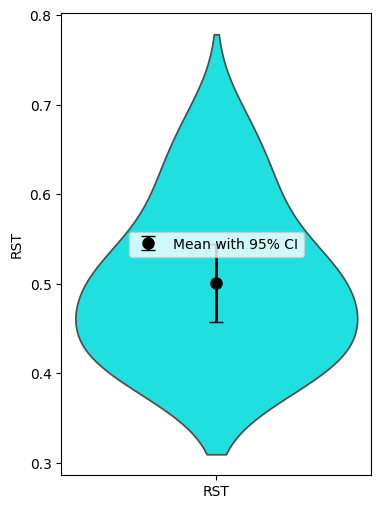

In [23]:
def plot_violin_ci(rst_array,group):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from scipy.stats import t
    
    
    # Calculate mean and standard error of the mean (SEM)
    mean_value = np.nanmean(rst_array)
    sem_value = np.nanstd(rst_array, ddof=1) / np.sqrt(np.sum(~np.isnan(rst_array)))
    
    # Calculate 95% confidence interval
    confidence_level = 0.95
    df = len(rst_array) - 1  # degrees of freedom
    ci_lower, ci_upper = t.interval(confidence_level, df, loc=mean_value, scale=sem_value)
    
    # Create a violin plot in grayscale
    plt.figure(figsize=(4, 6))
    # plt.figure(figsize=(8, 6))
    sns.violinplot(data=rst_array, width = 0.1, color='cyan', inner= None, density_norm='width')
    
    # Overlay the mean and 95% CI in grayscale
    plt.errorbar(0, mean_value, yerr=[[mean_value - ci_lower], [ci_upper - mean_value]], 
                 fmt='o', color='black', capsize=5, elinewidth=2, markersize=8, label='Mean with 95% CI')
    
    # Add labels and title
    plt.ylabel("RST")
    # plt.title("Violin Plot with Overlaid 95% CI as Error Bars")
    plt.xticks([0], [group])  # Set x-tick for single group
    
    # Show the plot
    plt.legend()
    plt.show()
plot_violin_ci(df_rst['RST'],'RST')

In [24]:
from scipy.stats import ttest_1samp
import numpy as np

def report_one_sample_ttest(
    data,
    mu=0.5,
    alpha=0.05,
    label="RST"
):
    data = np.asarray(data)
    data = data[~np.isnan(data)]

    t_stat, p_value = ttest_1samp(data, mu)

    mean_val = data.mean()
    sd_val = data.std(ddof=1)
    df = len(data) - 1
    cohens_d = (mean_val - mu) / sd_val

    # Direction & interpretation
    if p_value < alpha:
        if mean_val > mu:
            interpretation = "was significantly higher than"
        else:
            interpretation = "was significantly lower than"
    else:
        interpretation = "did not differ significantly from"

    # Format p-value
    if p_value < 0.001:
        p_str = "< .001"
    else:
        p_str = f"= {p_value:.3f}"

    report = (
        f"A one-sample, two-tailed t-test was conducted to compare {label} values "
        f"against the null value of {mu}. The mean {label} "
        f"(M = {mean_val:.3f}, SD = {sd_val:.3f}) "
        f"{interpretation} {mu}, "
        f"t({df}) = {t_stat:.3f}, p {p_str}, "
        f"Cohen’s d = {cohens_d:.3f}."
    )

    return report

In [25]:
print(report_one_sample_ttest(df_rst['RST'], mu=0.5, label="RST"))

A one-sample, two-tailed t-test was conducted to compare RST values against the null value of 0.5. The mean RST (M = 0.501, SD = 0.085) did not differ significantly from 0.5, t(16) = 0.053, p = 0.958, Cohen’s d = 0.013.


In [26]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import numpy as np

# Load BayesFactor package from R
BayesFactor = importr("BayesFactor")

# Convert Python list to R numeric vector
data = np.array(df_rst['RST'])
r_data = robjects.FloatVector(data)

# Perform Bayesian one-sample t-test (H0: mean = 0.5)
bf_result = BayesFactor.ttestBF(x=r_data, mu=0.5)
print(bf_result)

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 0.2492931 ±0.01%

Against denominator:
  Null, mu = 0.5 
---
Bayes factor type: BFoneSample, JZS




In [27]:
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects import FloatVector, r
from rpy2.robjects.packages import importr

# Load BayesFactor and extractBF
BayesFactor = importr("BayesFactor")
extractBF = r['extractBF']

data = np.array(df_rst['RST'])
bf_values = []
sample_sizes = []

for n in range(5, len(data) + 1):
    sample = data[:n]

    # Skip constant data
    if np.std(sample, ddof=1) < 1e-8:
        print(f"Skipped n={n}: data are constant")
        bf_values.append(np.nan)
        continue

    try:
        r_sample = FloatVector(sample)
        bf = BayesFactor.ttestBF(x=r_sample, mu=0.5)

        # Use extractBF to get the numeric BF10 value
        bf_table = extractBF(bf)
        bf_numeric = float(bf_table.rx2('bf')[0])  # extract from R dataframe
        bf_values.append(bf_numeric)
        sample_sizes.append(n)

    except Exception as e:
        print(f"Error at n={n}: {e}")
        bf_values.append(np.nan)

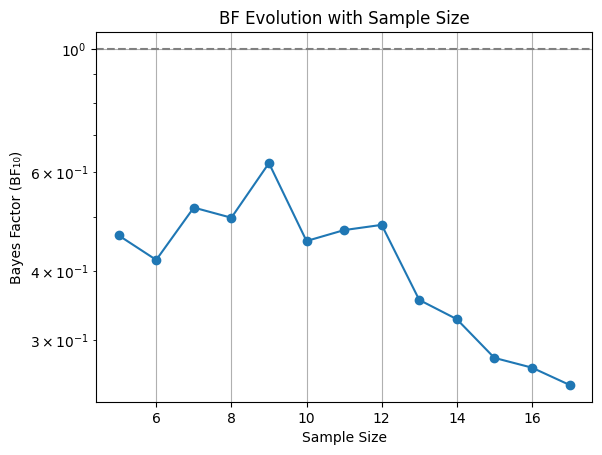

In [28]:
plt.plot(sample_sizes, bf_values, marker='o')
plt.axhline(1, color='gray', linestyle='--')
plt.yscale('log')
plt.xlabel("Sample Size")
plt.ylabel("Bayes Factor (BF₁₀)")
plt.title("BF Evolution with Sample Size")
plt.grid(True)
plt.show()